In [3]:
#this code is to test the pipeline to later implement in classes or functions, we will test each one

In [ ]:
#imputing/normalizing data
import numpy as np
import pandas as pd

#first test it manually, then test it using the pipeline
    
#now test it by loading in the data
metabolomics_file_path = 'UKBB_300K_Overlapping_MET.csv'
metabolomics_df = pd.read_csv(metabolomics_file_path, index_col=0)

proteomics_file_path = 'UKBB_300K_Overlapping_OLINK.csv'
proteomics_df = pd.read_csv(proteomics_file_path, index_col=0)

met = metabolomics_df.to_numpy()
prot = proteomics_df.to_numpy()
print(met.shape, prot.shape)

met = np.log10(met+1e-9)

#now find the min value of each column for prot
p_min = np.nanmin(prot, axis=0, )
print(p_min.shape)

In [ ]:
#now we will impute the missing values with the min value of each column
#first find the nan values
p_nan = np.isnan(prot)
print(p_nan.shape)

#now we loop through and replace the nan values with the min value of each column
for i in range(p_nan.shape[1]):
    prot[p_nan[:,i],i] = p_min[i]

(27337, 1461)


In [ ]:
print("NaN in prot:", np.isnan(prot).any())
print("NaN in met:", np.isnan(met).any())

NaN in prot: False
NaN in met: False


In [ ]:
#now we zscore the data using sklearn preprocessing
def z_score_normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean)/std

p_manual = z_score_normalize(prot)
m_manual = z_score_normalize(met)

print(m_manual.shape, p_manual.shape)

(27337, 251) (27337, 1461)


1138
6068


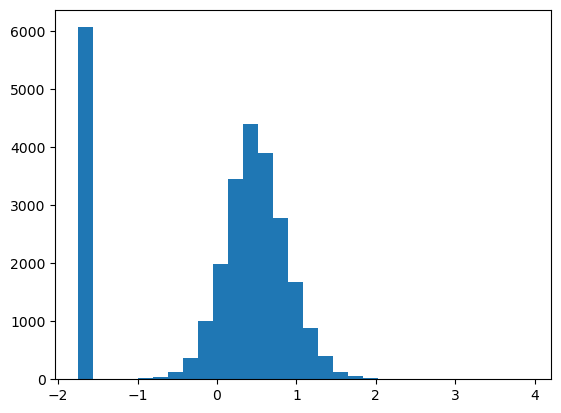

In [ ]:
#also plot some values of p to see how that affects things
#find the columsn of p_nan with the highest values
p_nan_sum = np.sum(p_nan, axis=0)
test = np.argmax(p_nan_sum)
print(test)
print(p_nan_sum[test])
check = p_manual[:,test]
import matplotlib.pyplot as plt

plt.hist(p_manual[:,test], bins=30)
plt.show()

#this imputation is potentially very problematic, but it seems fine for now I guess?

In [ ]:
#now let's use this class we've created
from sklearn.impute import SimpleImputer
class LoadData():
    def __init__(self, filename1, filename2, preprocess = True, impute = True):
        filemet = 'UKBB_300K_Overlapping_MET.csv'
        met = pd.read_csv(f'/home/sarthak/cornell/Krumsiek/{filemet}', index_col = 0)
        fileprot = 'UKBB_300K_Overlapping_OLINK.csv'
        prot = pd.read_csv(f'/home/sarthak/cornell/Krumsiek/{fileprot}', index_col = 0)
        met = met.to_numpy()
        prot = prot.to_numpy()
        if preprocess:
            met = self.preprocessor(met, datatype = 'met')
            prot = self.preprocessor(prot, datatype = 'prot', impute = impute)
        self.m = met
        self.p = prot
        return None
    
    def preprocessor(self, data, datatype = 'met', scale = True, impute = True): #potentially we add dealing with NaNs here
        if datatype == 'met':
            #first we log each dataset
            data = np.log10(data+1e-9)
            if scale:
                #now we scale each dataset
                data = self.zscore(data)
            return data
        if datatype == 'prot':
            if impute:
                #now we impute each dataset
                #first find min of each column
                min = np.nanmin(data, axis = 0)
                nan_pos = np.isnan(data)
                for i in range(nan_pos.shape[1]):
                    data[nan_pos[:,i],i] = min[i]
                #data = SimpleImputer(strategy = 'constant', fill_value=min).fit_transform(data)
            if scale:
                #now we scale each dataset
                data = self.zscore(data)
            return data
    def zscore(self, data):
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        return (data - mean)/std

In [ ]:
#now run this on the data
dataclass = LoadData(met, prot, preprocess = True, impute = True)
m_auto = dataclass.m
p_auto = dataclass.p

In [ ]:
#first print the shapes to ensure similarity
print(m_manual.shape, m_auto.shape)
print(p_manual.shape, p_auto.shape)

(27337, 251) (27337, 251)
(27337, 1461) (27337, 1461)


In [ ]:
#compare by finding the percent change of each element

import numpy as np

# Assuming m_auto, p_auto, m_manual, p_manual are your matrices

# Calculate absolute differences and percent changes for metabolomics (m)
m_abs_diff = np.abs(m_auto - m_manual)
m_max_abs_diff = np.nanmax(m_abs_diff)  # Using nanmax to ignore NaNs

m_percent_change = np.abs((m_auto - m_manual) / (m_manual + 1e-9)) * 100  # Adding a small value to avoid division by zero
m_max_percent_change = np.nanmax(m_percent_change)  # Using nanmax to ignore NaNs

# Calculate absolute differences and percent changes for proteomics (p)
p_abs_diff = np.abs(p_auto - p_manual)
p_max_abs_diff = np.nanmax(p_abs_diff)  # Using nanmax to ignore NaNs

p_percent_change = np.abs((p_auto - p_manual) / (p_manual + 1e-9)) * 100  # Adding a small value to avoid division by zero
p_max_percent_change = np.nanmax(p_percent_change)  # Using nanmax to ignore NaNs

print(f"Max absolute difference in metabolomics: {m_max_abs_diff}")
print(f"Max percent change in metabolomics: {m_max_percent_change}")

print(f"Max absolute difference in proteomics: {p_max_abs_diff}")
print(f"Max percent change in proteomics: {p_max_percent_change}")

Max absolute difference in metabolomics: 0.0
Max percent change in metabolomics: 0.0
Max absolute difference in proteomics: 0.0
Max percent change in proteomics: 0.0
0.0


In [ ]:
#loop over every element and see if any not equal

for i in range(m_manual.shape[0]):
    for j in range(m_manual.shape[1]):
        if m_manual[i,j] != m_auto[i,j]:
            print(i,j)
            print(m_manual[i,j], m_auto[i,j])
            print(m_percent_change[i,j])
            
for i in range(p_manual.shape[0]):
    for j in range(p_manual.shape[1]):
        if p_manual[i,j] != p_auto[i,j]:
            print(i,j)
            print(p_manual[i,j], p_auto[i,j])
            print(p_percent_change[i,j])
#literally perfectly identical!

In [ ]:
#now we'll work on the plotting part
def plot(data, labels = None, plottype = 0, mse = None, col_nums = None, datatype = 'met'):
    if plottype == 'samples':
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        axes = axes.flatten()
        if datatype == 'met':
            type = 'Metabolite'
        else:
            type = 'Protein'
        for i, col in enumerate(col_nums):
            ax = axes[i]
            #data = data_df[col].dropna()
            tempdata = data[:,i]
            ax.hist(tempdata, bins=50, edgecolor='black')
            ax.set_title(f'{type} ID: {col}')
            ax.set_xlabel('Expression Level')
            ax.set_ylabel('Frequency')

        plt.tight_layout()
        return fig, axes
    
    if plottype == 0:
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        for i, feature_idx in enumerate(mse):
            ax = axs.flatten()[i]
            ax.scatter(labels[:, feature_idx], data[:, feature_idx], alpha=0.5)
            ax.plot([min(labels[:, feature_idx]), max(labels[:, feature_idx])],
                    [min(labels[:, feature_idx]), max(labels[:, feature_idx])],
                    color='red', linestyle='--')
            R2 = np.corrcoef(labels[:, feature_idx], data[:, feature_idx])[0, 1] ** 2
            ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
            ax.set_xlabel('True Value')
            ax.set_ylabel('Predicted Value')
        return fig, axs
    
    if plottype == 1:
        fig, ax = plt.subplots()
        #now plot stuff
        return fig, ax
    
    if plottype == 2:
        fig, ax = plt.subplots()
        #now plot stuff
        return fig, ax

Text(0.5, 0.98, 'Metabolomics Data')

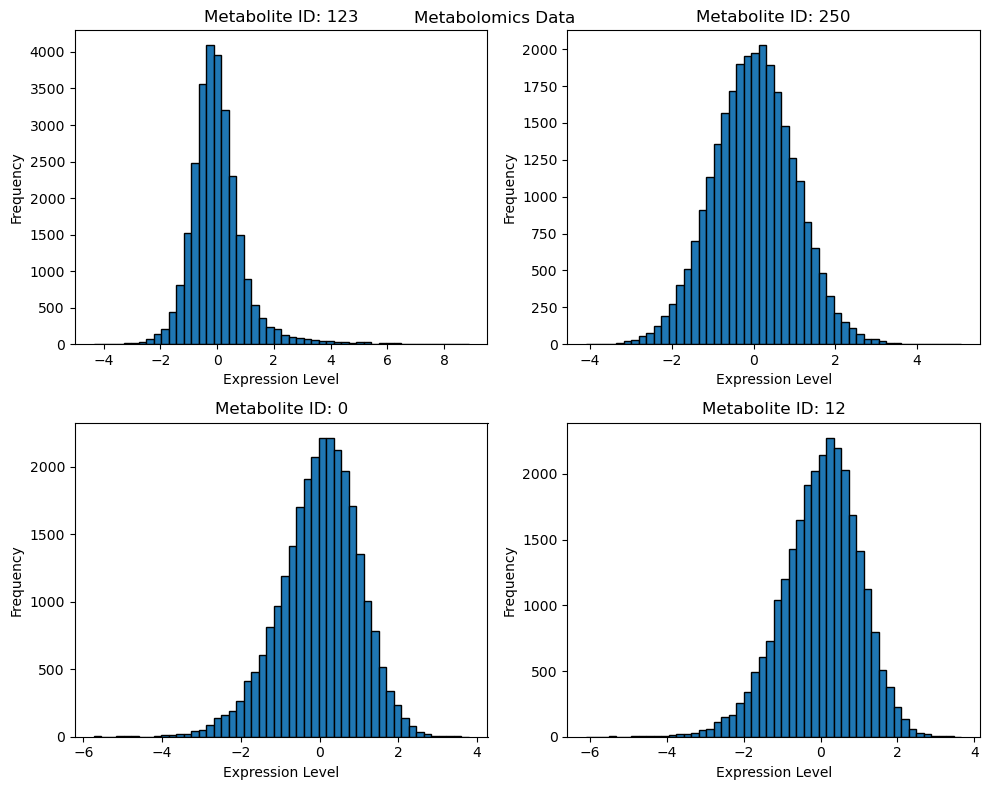

In [ ]:
#choose 4 random numbers to plot the metabolomic data
col_nums = [123, 250, 0, 12]
#now plot the data
fig,ax = plot(m_manual, plottype = 'samples', col_nums = col_nums, datatype = 'met')
#fig.tight_layout()
fig.show()
fig.suptitle('Metabolomics Data')

#it's approximately normal, still not perfect tho

# testing the kfold part

In [ ]:
#finally, we test the kfold part, here's what I made
from sklearn.model_selection import KFold
class CV():
    def __init__(self, met, prot):
        self.met = met
        self.prot = prot
        # self.n = n
        self.predict = np.zeros(self.prot.shape)
        
    def folds(self, n = 5, random_state = 42):
        #first we shuffle the data, then we return the folds, also use a random state
        #use kfold to split the data, then return it
        #also save out the fold numbeer, so we know how to save it, but basically when we get indices, we can just save it out
        
        self.fold_list = []
        #create n random groups
        kf = KFold(n_splits=n, shuffle=True, random_state=random_state)
        for train_idx, test_idx in kf.split(self.prot):
            self.fold_list.append(test_idx)
        
        #so we get n sets of indices, then we save the indices, then when we do k fold, we know which set of indices predicting
        #save out those ones in the end, so need to return the fold number alongside the indices
        #so loop through the folds, and then index into the fold_list
        return self.fold_list
    
    def save_out(self, predicts, fold):
        #saves out the data chunk by chunk
        self.predict[self.fold_list[fold],:] = predicts #basically it assigns it to the proper one, definitiley check, likely bug!

In [ ]:
#for a test, we'll just have predict be the same as the data
def predict(data):
    return data
import numpy as np
#import the data
import os
os.chdir('/home/sarthak/cornell/Krumsiek')
from utils import LoadData
# from utils import CV
dataclass = LoadData()
m = dataclass.m
p = dataclass.p

#now we'll test it
cv = CV(m,p)

fold_list = cv.folds(n = 5, random_state = 42)
print(len(fold_list))

5


In [ ]:
for i in fold_list:
    print(i.shape)

(5468,)
(5468,)
(5467,)
(5467,)
(5467,)


In [ ]:
#now we do the 'train loop'
for i in range(len(fold_list)):
    #get the indices
    test_idx = fold_list[i]
    #get the data
    test_data = p[test_idx,:]
    #predict the data
    pred = predict(test_data)
    #save out the data
    cv.save_out(pred, i)

In [ ]:
#now we compare the data to the original data
print(cv.predict.shape, p.shape)

(27337, 1461) (27337, 1461)


In [ ]:
print(np.max(cv.predict-p))

0.0


In [ ]:
#now the real test is to have predict function just return 2 more than the actual thing, then we can see the mean if it's 2 and the max
def predict(data):
    return data+2
cv = CV(m,p)
fold_list = cv.folds(n = 5, random_state = 42)
for i in range(len(fold_list)):
    #get the indices
    test_idx = fold_list[i]
    #get the data
    test_data = p[test_idx,:]
    #predict the data
    pred = predict(test_data)
    #save out the data
    cv.save_out(pred, i)

In [ ]:
#now compare the data
print(np.max(cv.predict-p))
print(np.mean(cv.predict-p))

2.0000000000000018
2.0


# plotting

In [ ]:
from sklearn.model_selection import KFold
class CV():
    def __init__(self, met, prot):
        self.met = met
        self.prot = prot
        # self.n = n
        self.predict = np.zeros(self.prot.shape)
        
    def folds(self, n = 5, random_state = 42):
        #first we shuffle the data, then we return the folds, also use a random state
        #use kfold to split the data, then return it
        #also save out the fold numbeer, so we know how to save it, but basically when we get indices, we can just save it out
        
        self.fold_list = []
        #create n random groups
        kf = KFold(n_splits=n, shuffle=True, random_state=random_state)
        for train_idx, test_idx in kf.split(self.prot):
            self.fold_list.append(test_idx)
        
        #so we get n sets of indices, then we save the indices, then when we do k fold, we know which set of indices predicting
        #save out those ones in the end, so need to return the fold number alongside the indices
        #so loop through the folds, and then index into the fold_list
        return self.fold_list
    
    def save_out(self, predicts, fold):
        #saves out the data chunk by chunk
        self.predict[self.fold_list[fold],:] = predicts #basically it assigns it to the proper one, definitiley check, likely bug!
    
    def idx_plot(self, feature_list = None):
        #plots the best ones corresponding to the indices, and by default it will plot the 4 most correlated ones
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        labels = self.prot
        data = self.predict
        mse = feature_list
        if mse is None: #if mse is empty, then we just plot the 4 most correlated ones whcih have lowest mse
            mse = np.argsort(np.mean((labels - data) ** 2, axis=0))[:4]
        for i, feature_idx in enumerate(mse):
            ax = axs.flatten()[i]
            ax.scatter(labels[:, feature_idx], data[:, feature_idx], alpha=0.5)
            ax.plot([min(labels[:, feature_idx]), max(labels[:, feature_idx])],
                    [min(labels[:, feature_idx]), max(labels[:, feature_idx])],
                    color='red', linestyle='--')
            R2 = np.corrcoef(labels[:, feature_idx], data[:, feature_idx])[0, 1] ** 2
            ax.set_title(f'Feature {feature_idx} (MSE: {mse[i]:.4f}, R2: {R2:.4f})')
            ax.set_xlabel('True Value')
            ax.set_ylabel('Predicted Value')
        return fig, axs

In [ ]:
#now it seems that we have a sufficient pipeline! 
#Let's do a final thing by plotting the data and creating a relatively pretty plot, first we will start with linear regression!

#first we need to get the data
import os
os.chdir('/home/sat4017/prot_project/')
import numpy as np

from utils import LoadData
#from utils import CV

dataloader = LoadData()
m = dataloader.m
p = dataloader.p

#now we need to do the linear regression with the k fold cross validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cv = CV(m,p)
fold_list = cv.folds(n = 5, random_state = 42)
for i in range(len(fold_list)):
    #get the indices
    test_idx = fold_list[i]
    #get the data
    m_train = np.delete(m, test_idx, axis = 0) #axis 0 deletes the rows with the test_idx as we hope
    m_test = m[test_idx,:]
    p_train = np.delete(p, test_idx, axis = 0)
    p_test = p[test_idx,:]
    #predict the data
    reg = LinearRegression().fit(m_train, p_train)
    pred = reg.predict(m_test)
    #save out the data
    cv.save_out(pred, i)

In [ ]:
print(cv.predict.shape, p.shape)
#also check to see if any row or column is all zeros
print(np.min(np.abs(np.sum(cv.predict, axis = 0))))
print(np.min(np.abs(np.sum(cv.predict, axis = 1))))

#clearly no axis is zero

(27337, 1461) (27337, 1461)
1.7335125705282
0.0038383046289647282


In [ ]:
mse = np.argsort(np.mean((cv.predict - p) ** 2, axis=0))[::-1][:4]
print(mse.shape)
print(np.mean((cv.predict - p) ** 2, axis=0).shape)

(4,)
(1461,)


(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Feature 1136 (MSE: 1136.0000, R2: 0.0005)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 3 (MSE: 3.0000, R2: 0.0000)'}, xlabel='True Value', ylabel='Predicted Value'>],
        [<Axes: title={'center': 'Feature 1263 (MSE: 1263.0000, R2: 0.0003)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 366 (MSE: 366.0000, R2: 0.0000)'}, xlabel='True Value', ylabel='Predicted Value'>]],
       dtype=object))

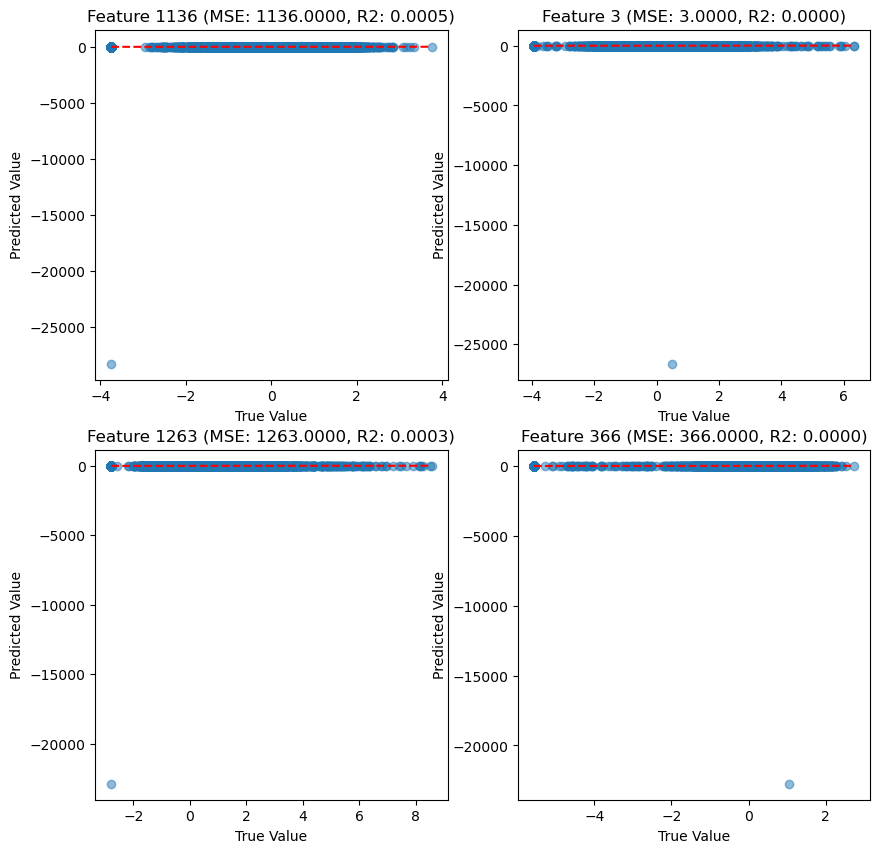

In [ ]:
#now we can create a plot that will be quite good!
#since doing modular approach, can add stuff later, let's start with this basic plotting function and approach

#it's added into our CV class which makes sense, already has the data, so we can just plot it
import matplotlib.pyplot as plt
cv.idx_plot(mse)

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Feature 406 (MSE: 406.0000, R2: 0.0873)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 1021 (MSE: 1021.0000, R2: 0.0640)'}, xlabel='True Value', ylabel='Predicted Value'>],
        [<Axes: title={'center': 'Feature 1415 (MSE: 1415.0000, R2: 0.0726)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 1010 (MSE: 1010.0000, R2: 0.0002)'}, xlabel='True Value', ylabel='Predicted Value'>]],
       dtype=object))

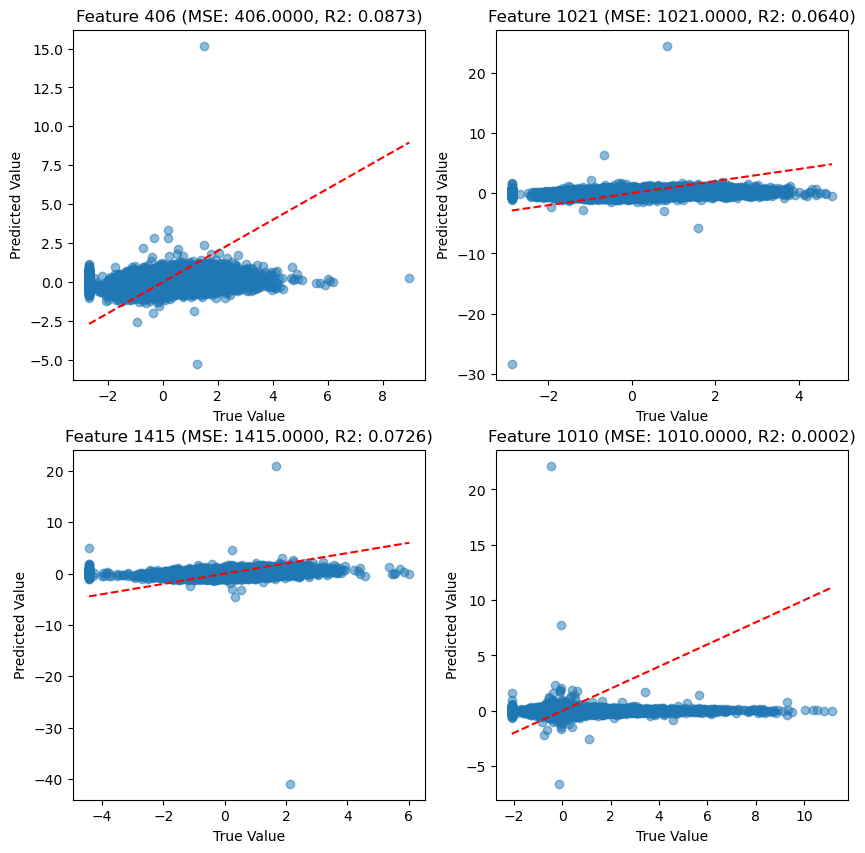

In [ ]:
cv.idx_plot()

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(m, p, test_size=0.2, random_state=42)

#fit the model
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')


In [ ]:
print(mse.shape)

(1461,)


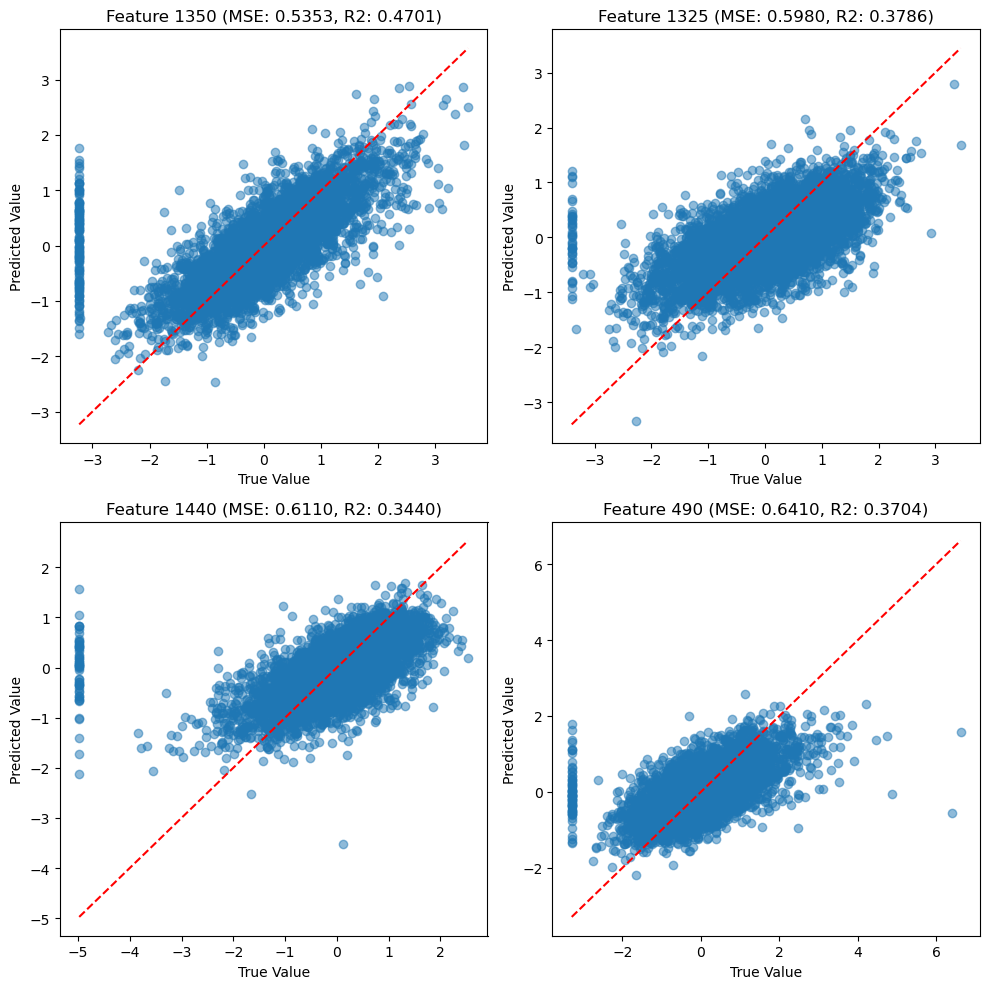

In [ ]:

lowest_mse = np.argsort(mse)[:4]
f_idx = lowest_mse

#now plot the data
def plot_fct(y_pred, y_test, mse_idx, mse):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, feature_idx in enumerate(mse_idx):
        ax = axs[i]
        ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
        ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                color='red', linestyle='--')
        R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
        ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()
    
plot_fct(y_pred, y_test, f_idx, mse)

In [ ]:
#once again we see that it's an issue with our imputation being minimum, this is clearly an issue, we need to somehow fix this first, can try KNN, previously did mean and much better
#here you see the fact that there's so many minimum values, wait it's predicting that? no it's predicting closer to mean even if true i slike 0... let's try KNN?

# Imputation is the bigger issue

## remember to restart kernel between sections

In [17]:
import numpy as np
import pandas as pd

from utils import CV

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
class LoadData():
    def __init__(self, filemet = 'UKBB_300K_Overlapping_MET.csv', fileprot = 'UKBB_300K_Overlapping_OLINK.csv', preprocess = True, impute = None, removenan = True):
        met = pd.read_csv(f'/home/sat4017/prot_project/{filemet}', index_col = 0)
        prot = pd.read_csv(f'/home/sat4017/prot_project/{fileprot}', index_col = 0)
        met = met.to_numpy()
        prot = prot.to_numpy()
        if preprocess:
            prot = self.preprocessor(prot, datatype = 'prot', impute = impute, removenan = removenan)
            met = self.preprocessor(met, datatype = 'met', impute = impute, removenan = removenan)
        self.m = met
        self.p = prot
        return None
    
    def preprocessor(self, data, datatype = 'met', scale = True, impute = None, removenan = True): #potentially we add dealing with NaNs here
        if datatype == 'met':
            #first we log each dataset
            if removenan: #uses the stored rows and columns we are supposed to keep to make them the same size and removes the associated values from the other dataset
                #if we remove samples from one, we have to remove samples from the other, but only the rows are the issue
                data = data[self.rowkeep,:]
            data = np.log10(data+1e-9)
            if scale:
                #now we scale each dataset
                data = self.zscore(data)
            return data
        
        if datatype == 'prot':
            if removenan:
                #first we remove the nan values
                data = self.filter_fct(data, 200, 500) #this threshold keeps a lot more proteins but removes about 2000 columns, makes sense though
                
            if impute == 'min':
                #now we impute each dataset
                #first find min of each column
                min = np.nanmin(data, axis = 0)
                nan_pos = np.isnan(data)
                for i in range(nan_pos.shape[1]):
                    data[nan_pos[:,i],i] = min[i]
                #data = SimpleImputer(strategy = 'constant', fill_value=min).fit_transform(data)
            elif impute == 'mean':
                data = SimpleImputer(strategy = 'mean').fit_transform(data)
            elif impute == 'KNN':
                data = KNNImputer(n_neighbors=5).fit_transform(data)
                
            if scale:
                #now we scale each dataset
                data = self.zscore(data)
            return data
        
    def zscore(self, data):
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        return (data - mean)/std
    
    def filter_fct(self, array, row_threshold, col_threshold, print_shape = False):
        #this function does what I propose
        row_nan_count = np.isnan(array).sum(axis=1)
        self.rowkeep = np.where(row_nan_count <= row_threshold)[0]
        filtered_array_by_row = array[row_nan_count <= row_threshold, :]
        
        col_nan_count = np.isnan(filtered_array_by_row).sum(axis=0)
        #self.colkeep = np.where(col_nan_count <= col_threshold)[0]
        filtered_array_by_row_and_col = filtered_array_by_row[:, col_nan_count <= col_threshold]
        
        if print_shape:
            print("Original array shape:", array.shape)
            print("Array shape after removing both", filtered_array_by_row_and_col.shape)
            print('numer of NaNs in filtered array', np.sum(np.isnan(filtered_array_by_row_and_col)))
            print('\n')
        return filtered_array_by_row_and_col

In [3]:
#before knn imputation, we need to first remove many of the egregious rows and columns with NaN values, the plot of which was found before
def filter_fct(array, row_threshold, col_threshold, print_shape = False):
    #this function does what I propose
    row_nan_count = np.isnan(array).sum(axis=1)
    filtered_array_by_row = array[row_nan_count <= row_threshold, :]
    
    col_nan_count = np.isnan(filtered_array_by_row).sum(axis=0)
    filtered_array_by_row_and_col = filtered_array_by_row[:, col_nan_count <= col_threshold]
    
    if print_shape:
        print("Original array shape:", array.shape)
        print("Array shape after removing both", filtered_array_by_row_and_col.shape)
        print('numer of NaNs in filtered array', np.sum(np.isnan(filtered_array_by_row_and_col)))
        print('\n')
    return filtered_array_by_row_and_col

dataloader = LoadData(impute = False, preprocess = False, removenan = False)
p = dataloader.p
#print amount of NA in p
print(np.sum(np.isnan(p)))

1085219


In [11]:
a = filter_fct(p, 200, 500, print_shape = True) #down to 1/4 of the NaNs, so now can do imputation

Original array shape: (27337, 1461)
Array shape after removing both (25818, 1039)
numer of NaNs in filtered array 227531




In [18]:
#let's try the KNN imputer and do everything as before
dataloader = LoadData(impute = 'KNN')
m = dataloader.m
p = dataloader.p

#now we need to do the linear regression with the k fold cross validation
from sklearn.linear_model import LinearRegression

cv = CV(m,p)

fold_list = cv.folds(n = 5, random_state = 42)

#KNN algorithm is a little slow, but we do have it

In [19]:
for i in range(len(fold_list)):
    #get the indices
    test_idx = fold_list[i]
    #get the data
    m_train = np.delete(m, test_idx, axis = 0) #axis 0 deletes the rows with the test_idx as we hope
    m_test = m[test_idx,:]
    p_train = np.delete(p, test_idx, axis = 0)
    p_test = p[test_idx,:]
    #predict the data
    reg = LinearRegression().fit(m_train, p_train)
    pred = reg.predict(m_test)
    #save out the data
    cv.save_out(pred, i)
    
mse = np.argsort(np.mean((cv.predict - p) ** 2, axis=0))[::-1][:4]

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Feature 136 (MSE: 136.0000, R2: 0.0000)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 26 (MSE: 26.0000, R2: 0.0000)'}, xlabel='True Value', ylabel='Predicted Value'>],
        [<Axes: title={'center': 'Feature 405 (MSE: 405.0000, R2: 0.0001)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 188 (MSE: 188.0000, R2: 0.0000)'}, xlabel='True Value', ylabel='Predicted Value'>]],
       dtype=object))

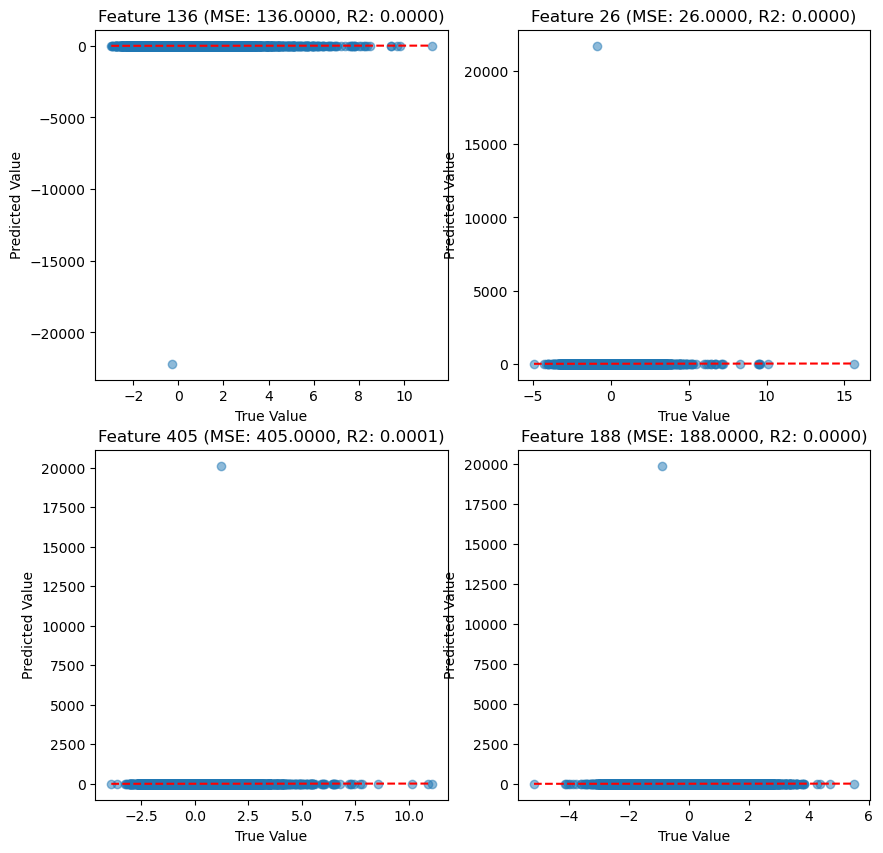

In [23]:
cv.idx_plot(mse)

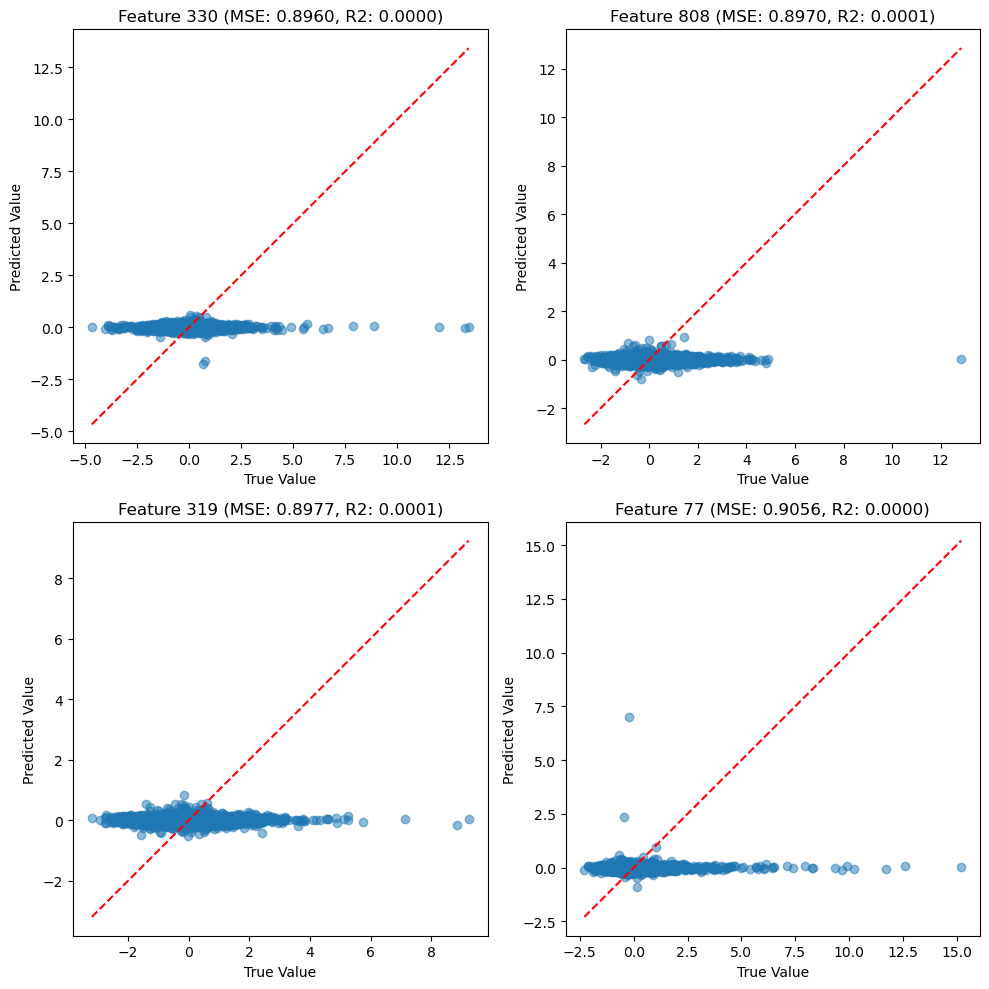

In [27]:
#now test the old kind again

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(m, p, test_size=0.2, random_state=42)

#fit the model
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

lowest_mse = np.argsort(mse)[:4]
f_idx = lowest_mse

#now plot the data
def plot_fct(y_pred, y_test, mse_idx, mse):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, feature_idx in enumerate(mse_idx):
        ax = axs[i]
        ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
        ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                color='red', linestyle='--')
        R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
        ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()
    
plot_fct(y_pred, y_test, f_idx, mse)

In [28]:
#now the preddictions are absolutely horrendous? Is there something wrong with the imputation somehow?
#Did we remove ones that were highly correlated somehow and now they are all trash? Was it the fact that we imputed that made them good

#oh shoot, that's a good question, let's revisit and see which ones are the most imputed and see what happened, maybewe removed the important proteins... maybe have to change that threshold?
#can remove more samples maybe? idk... let's see

#we also got to see that the time went from 5 minutes to 4 seconds for imputation, something is definitely wrong!

#manual implementation time!!

#read in the files

metabolomics_file_path = 'UKBB_300K_Overlapping_MET.csv'
metabolomics_df = pd.read_csv(metabolomics_file_path, index_col=0)

proteomics_file_path = 'UKBB_300K_Overlapping_OLINK.csv'
proteomics_df = pd.read_csv(proteomics_file_path, index_col=0)

met = metabolomics_df.to_numpy()
prot = proteomics_df.to_numpy()
print(met.shape, prot.shape)

#met = np.log10(met+1e-9)

#remove nan, impute, and scale, let's remove nan based on a threshold like before

array = prot.copy()
row_nan_count = np.isnan(array).sum(axis=1)
kept_rows = np.where(row_nan_count <= 200)[0]
filtered_array_by_row = array[row_nan_count <= 200, :]

# Step 2: Remove columns with at least one NaN
col_nan_count = np.isnan(filtered_array_by_row).sum(axis=0)
filtered_array_by_row_and_col = filtered_array_by_row[:, col_nan_count <= 500]

#now remove the rows in the metabolomics
m = met[kept_rows,:]

m = np.log10(m+1e-9)

#now we impute into the proteins
p = filtered_array_by_row_and_col
#now use knn imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
p = imputer.fit_transform(p)

#now we scale
def zscore(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean)/std

m = zscore(m)
p = zscore(p)
print(m.shape, dataloader.m.shape)
print(p.shape, dataloader.p.shape)

(27337, 251) (27337, 1461)
(25818, 251) (25818, 251)
(25818, 1039) (25818, 1039)


In [32]:
#find the maximuma bsolute difference between the vectors m and dataloader.m

print(np.max(np.abs(m-dataloader.m)))
print(np.max(np.abs(p-dataloader.p)))

#now find the percent difference
print(np.max(np.abs(m-dataloader.m)/(m+1e-9)))
print(np.max(np.abs(p-dataloader.p)/(p+1e-9)))

#clearly there's something very wrong with the metabolites, the proteins seem perfeclty fine, is it the logging??

158.6337579533896
7.105427357601002e-15
562876.0854529717
1.4231945902953142e-10


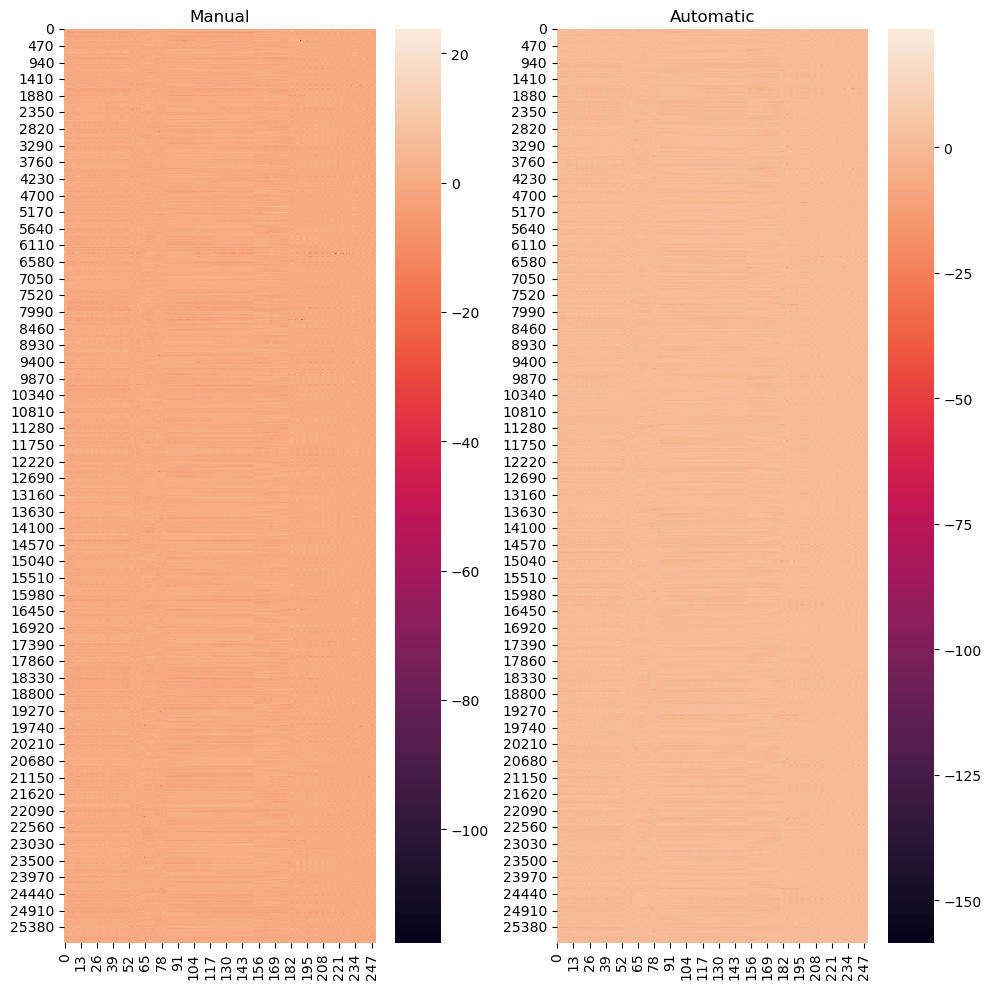

In [31]:
#heatmap of the two m matrices, do 2 subplots
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()
sns.heatmap(m, ax = axs[0])
sns.heatmap(dataloader.m, ax = axs[1])
axs[0].set_title('Manual')
axs[1].set_title('Automatic')
plt.tight_layout()
plt.show()

In [33]:
#now find max difference of kept rows and self.rowskeep
print(np.max(np.abs(kept_rows-dataloader.rowkeep)))

1519


In [34]:
print(kept_rows.shape, dataloader.rowkeep.shape)

(25818,) (25818,)


In [35]:
#what if we fit using m and p that we calculated manually instead?

#let's try the KNN imputer and do everything as before
# dataloader = LoadData(impute = 'KNN')
# m = dataloader.m
# p = dataloader.p

#now we need to do the linear regression with the k fold cross validation
from sklearn.linear_model import LinearRegression

cv = CV(m,p)

fold_list = cv.folds(n = 5, random_state = 42)

#KNN algorithm is a little slow, but we do have it
for i in range(len(fold_list)):
    #get the indices
    test_idx = fold_list[i]
    #get the data
    m_train = np.delete(m, test_idx, axis = 0) #axis 0 deletes the rows with the test_idx as we hope
    m_test = m[test_idx,:]
    p_train = np.delete(p, test_idx, axis = 0)
    p_test = p[test_idx,:]
    #predict the data
    reg = LinearRegression().fit(m_train, p_train)
    pred = reg.predict(m_test)
    #save out the data
    cv.save_out(pred, i)
    
mse = np.argsort(np.mean((cv.predict - p) ** 2, axis=0))[::-1][:4]

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Feature 402 (MSE: 402.0000, R2: 0.0042)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 903 (MSE: 903.0000, R2: 0.0053)'}, xlabel='True Value', ylabel='Predicted Value'>],
        [<Axes: title={'center': 'Feature 633 (MSE: 633.0000, R2: 0.0195)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 696 (MSE: 696.0000, R2: 0.0300)'}, xlabel='True Value', ylabel='Predicted Value'>]],
       dtype=object))

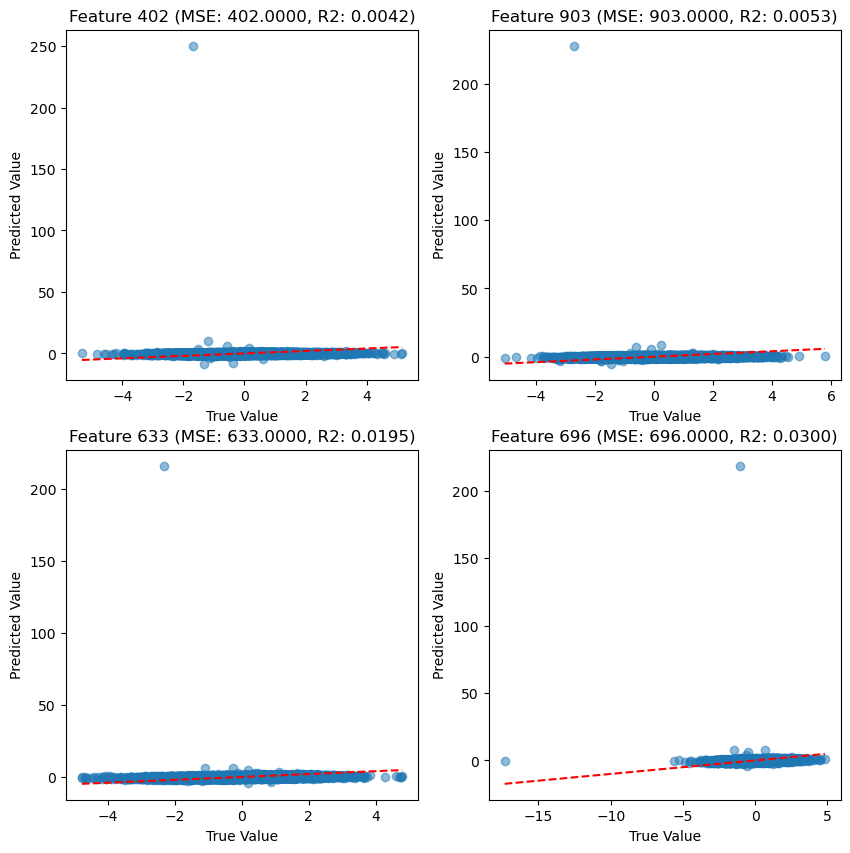

In [36]:
#and plot
cv.idx_plot(mse)

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Feature 1030 (MSE: 1030.0000, R2: 0.0793)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 40 (MSE: 40.0000, R2: 0.0450)'}, xlabel='True Value', ylabel='Predicted Value'>],
        [<Axes: title={'center': 'Feature 30 (MSE: 30.0000, R2: 0.0380)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 886 (MSE: 886.0000, R2: 0.0049)'}, xlabel='True Value', ylabel='Predicted Value'>]],
       dtype=object))

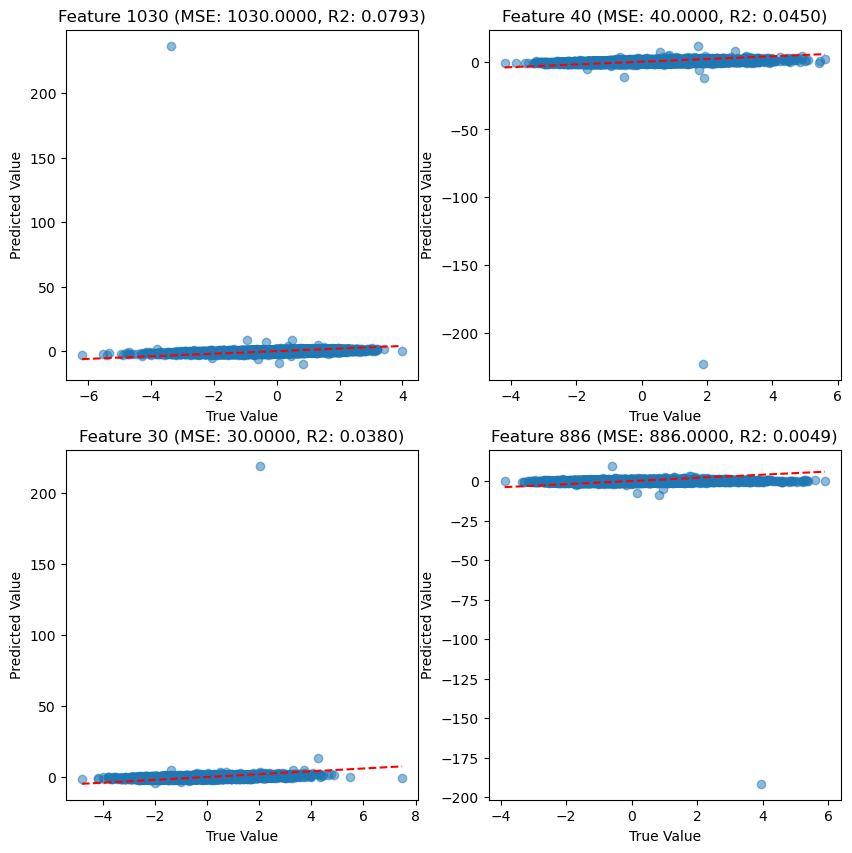

In [43]:
cv = CV(m,p)
from sklearn.linear_model import Ridge

fold_list = cv.folds(n = 2, random_state = 420)

#KNN algorithm is a little slow, but we do have it
for i in range(len(fold_list)):
    #get the indices
    test_idx = fold_list[i]
    #get the data
    m_train = np.delete(m, test_idx, axis = 0) #axis 0 deletes the rows with the test_idx as we hope
    m_test = m[test_idx,:]
    p_train = np.delete(p, test_idx, axis = 0)
    p_test = p[test_idx,:]
    #predict the data
    reg = Ridge(alpha=0.1).fit(m_train, p_train)
    pred = reg.predict(m_test)
    #save out the data
    cv.save_out(pred, i)
    
mse = np.argsort(np.mean((cv.predict - p) ** 2, axis=0))[::-1][:4]
cv.idx_plot(mse)

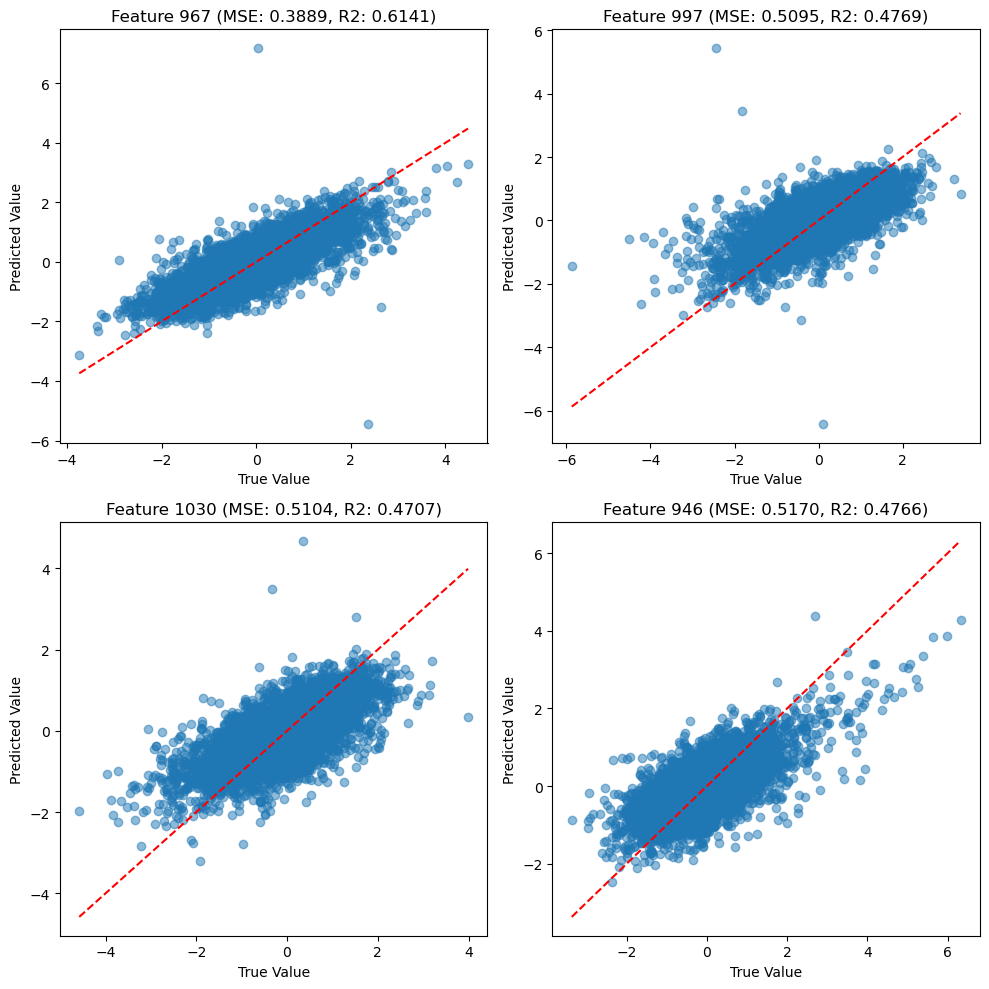

In [37]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(m, p, test_size=0.2, random_state=42)

#fit the model
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

lowest_mse = np.argsort(mse)[:4]
f_idx = lowest_mse

#now plot the data
def plot_fct(y_pred, y_test, mse_idx, mse):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, feature_idx in enumerate(mse_idx):
        ax = axs[i]
        ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
        ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                color='red', linestyle='--')
        R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
        ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()
    
plot_fct(y_pred, y_test, f_idx, mse)

#huh, what do you know? some of the correlated features were removed, but somehow somewhere in that data loader it messes thigns up... have to figure this out!

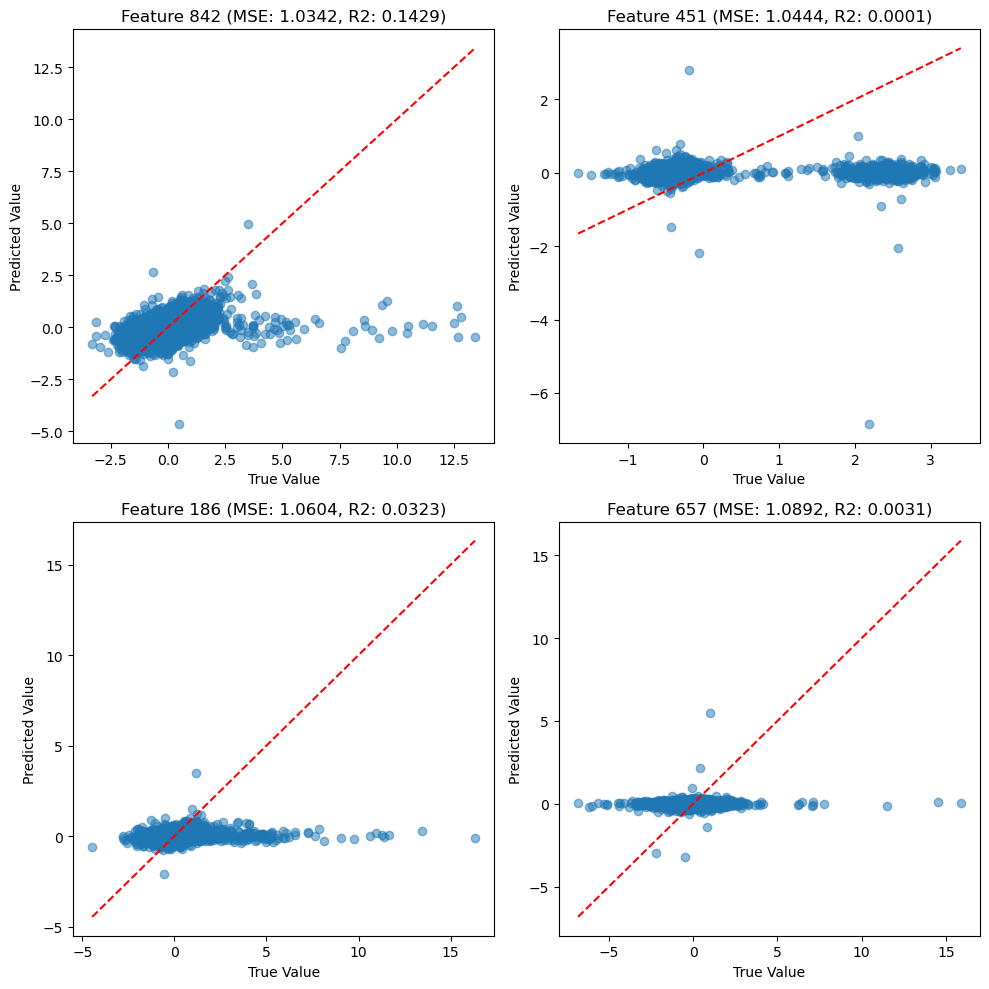

In [38]:
highestmse = np.argsort(mse)[-4:]
f_idx = highestmse

plot_fct(y_pred, y_test, f_idx, mse)

In [44]:
#finally let's make sure mean and std is normal for all of them, find the highest absolute value for mean and std
print(np.max(np.abs(np.mean(m, axis = 0))))
print(np.max(np.abs(np.mean(dataloader.m, axis = 0))))
print(np.max(np.abs(np.std(m, axis = 0))))
print(np.max(np.abs(np.std(dataloader.m, axis = 0))))

#yeah, so is scaled, but again seems to be scaled differently somehow, can figure it out in a debugger I guess!

1.4644421081965078e-11
1.3737201229018689e-11
1.0000000000000138
1.000000000000012


In [ ]:
#So, there are 2 core problems, the preprocessing somehow in my automatic one, along with the k fold CV somehow causing issues, somewhere in both of them is an obvious bug
#we know this because regardless k fold  is bad, but when manually calculate m and p, somehow the manual Ridge work sperfect... so it's definitely something in the preprocessing and k fold

In [1]:
#think I fixed bug 1, let's test it
import numpy as np
import pandas as pd

from utils import CV

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
class LoadData():
    def __init__(self, filemet = 'UKBB_300K_Overlapping_MET.csv', fileprot = 'UKBB_300K_Overlapping_OLINK.csv', preprocess = True, impute = None, removenan = True):
        met = pd.read_csv(f'/home/sat4017/prot_project/{filemet}', index_col = 0)
        prot = pd.read_csv(f'/home/sat4017/prot_project/{fileprot}', index_col = 0)
        met = met.to_numpy()
        prot = prot.to_numpy()
        if preprocess:
            prot = self.preprocessor(prot, datatype = 'prot', impute = impute, removenan = removenan)
            met = self.preprocessor(met, datatype = 'met', impute = impute, removenan = removenan)
        self.m = met
        self.p = prot
        return None
    
    def preprocessor(self, data, datatype = 'met', scale = True, impute = None, removenan = True): #potentially we add dealing with NaNs here
        if datatype == 'met':
            #first we log each dataset
            if removenan: #uses the stored rows and columns we are supposed to keep to make them the same size and removes the associated values from the other dataset
                #if we remove samples from one, we have to remove samples from the other, but only the rows are the issue
                data = data[self.rowkeep,:]
            data = np.log10(data+1e-9)
            if scale:
                #now we scale each dataset
                data = self.zscore(data)
            return data
        
        if datatype == 'prot':
            if removenan:
                #first we remove the nan values
                data = self.filter_fct(data, 200, 500) #this threshold keeps a lot more proteins but removes about 2000 columns, makes sense though
                
            if impute == 'min':
                #now we impute each dataset
                #first find min of each column
                min = np.nanmin(data, axis = 0)
                nan_pos = np.isnan(data)
                for i in range(nan_pos.shape[1]):
                    data[nan_pos[:,i],i] = min[i]
                #data = SimpleImputer(strategy = 'constant', fill_value=min).fit_transform(data)
            elif impute == 'mean':
                data = SimpleImputer(strategy = 'mean').fit_transform(data)
            elif impute == 'KNN':
                data = KNNImputer(n_neighbors=5).fit_transform(data)
                
            if scale:
                #now we scale each dataset
                data = self.zscore(data)
            return data
        
    def zscore(self, data):
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        return (data - mean)/std
    
    def filter_fct(self, array, row_threshold, col_threshold, print_shape = False):
        #this function does what I propose
        row_nan_count = np.isnan(array).sum(axis=1)
        self.rowkeep = np.where(row_nan_count <= row_threshold)[0]
        filtered_array_by_row = array[row_nan_count <= row_threshold, :]
        
        col_nan_count = np.isnan(filtered_array_by_row).sum(axis=0)
        #self.colkeep = np.where(col_nan_count <= col_threshold)[0]
        filtered_array_by_row_and_col = filtered_array_by_row[:, col_nan_count <= col_threshold]
        
        if print_shape:
            print("Original array shape:", array.shape)
            print("Array shape after removing both", filtered_array_by_row_and_col.shape)
            print('numer of NaNs in filtered array', np.sum(np.isnan(filtered_array_by_row_and_col)))
            print('\n')
        return filtered_array_by_row_and_col

In [2]:
dataloader = LoadData(impute = 'mean')

metabolomics_file_path = 'UKBB_300K_Overlapping_MET.csv'
metabolomics_df = pd.read_csv(metabolomics_file_path, index_col=0)

proteomics_file_path = 'UKBB_300K_Overlapping_OLINK.csv'
proteomics_df = pd.read_csv(proteomics_file_path, index_col=0)

met = metabolomics_df.to_numpy()
prot = proteomics_df.to_numpy()
print(met.shape, prot.shape)

#met = np.log10(met+1e-9)

#remove nan, impute, and scale, let's remove nan based on a threshold like before

array = prot.copy()
row_nan_count = np.isnan(array).sum(axis=1)
kept_rows = np.where(row_nan_count <= 200)[0]
filtered_array_by_row = array[row_nan_count <= 200, :]

# Step 2: Remove columns with at least one NaN
col_nan_count = np.isnan(filtered_array_by_row).sum(axis=0)
filtered_array_by_row_and_col = filtered_array_by_row[:, col_nan_count <= 500]

#now remove the rows in the metabolomics
m = met[kept_rows,:]

m = np.log10(m+1e-9)

#now we impute into the proteins
p = filtered_array_by_row_and_col
#now use knn imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
p = imputer.fit_transform(p)

#now we scale
def zscore(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean)/std

m = zscore(m)
p = zscore(p)
print(m.shape, dataloader.m.shape)
print(p.shape, dataloader.p.shape)

(27337, 251) (27337, 1461)
(25818, 251) (25818, 251)
(25818, 1039) (25818, 1039)


In [3]:
def find_diff(m1,p1,m2,p2):
    print(np.max(np.abs(m1-m2)))
    print(np.max(np.abs(p1-p2)))

    #now find the percent difference
    print(np.max(np.abs(m1-m2)/(m1+1e-9)))
    print(np.max(np.abs(p1-p2)/(p1+1e-9)))
    
find_diff(m,p,dataloader.m,dataloader.p)

#yup indeed... it was because we had defined somethign in terms of p which we then later defined as something else, so when we run the class uses the global variable p... no wonder we failed so hard!

0.0
0.0
-0.0
-0.0


## testing CV

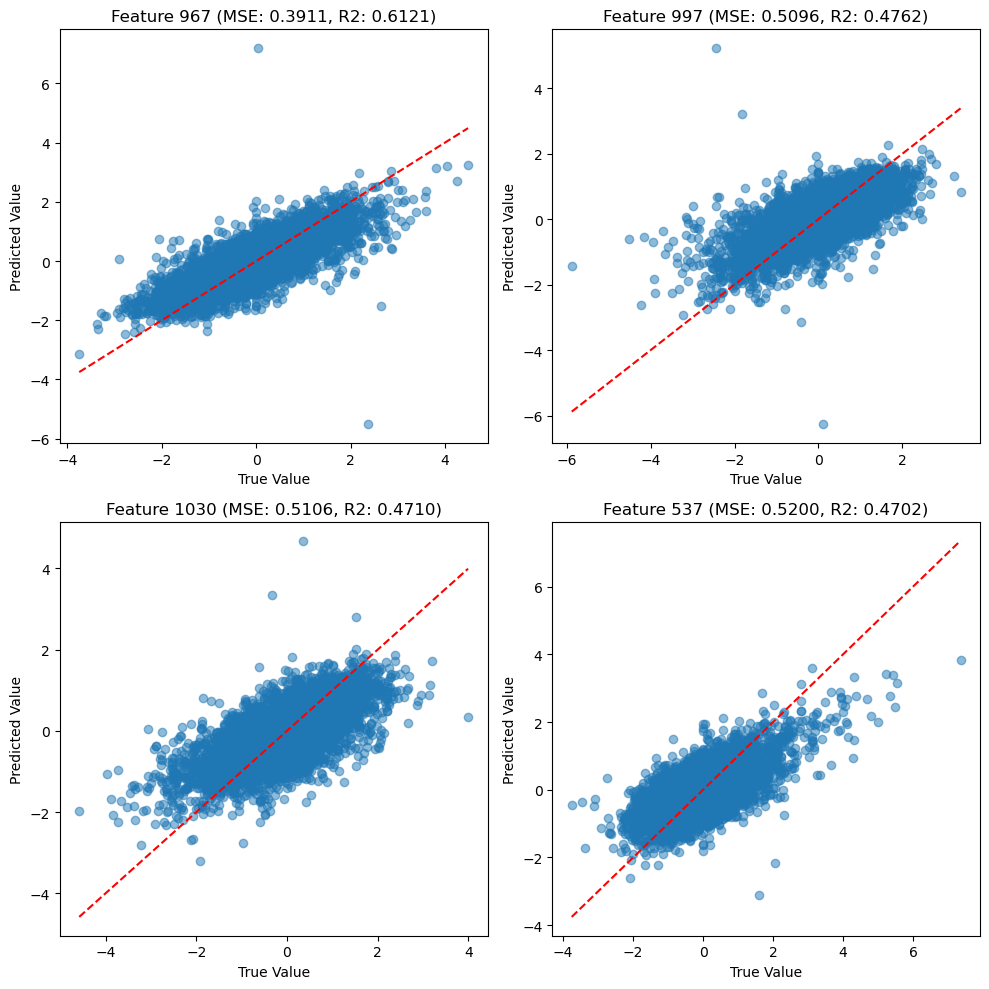

In [1]:
#now we know that we can load in data correctly, let's first set up a basic training loop using linear regression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from utils import LoadData
import numpy as np
dataloader = LoadData(impute = 'mean')
m = dataloader.m
p = dataloader.p

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(m, p, test_size=0.2, random_state=42)

#fit the model
model = Ridge(alpha=0.1, random_state=42)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

lowest_mse = np.argsort(mse)[:4]
f_idx = lowest_mse

#now plot the data
def plot_fct(y_pred, y_test, mse_idx, mse):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, feature_idx in enumerate(mse_idx):
        ax = axs[i]
        ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
        ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                color='red', linestyle='--')
        R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
        ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()
    
plot_fct(y_pred, y_test, f_idx, mse)

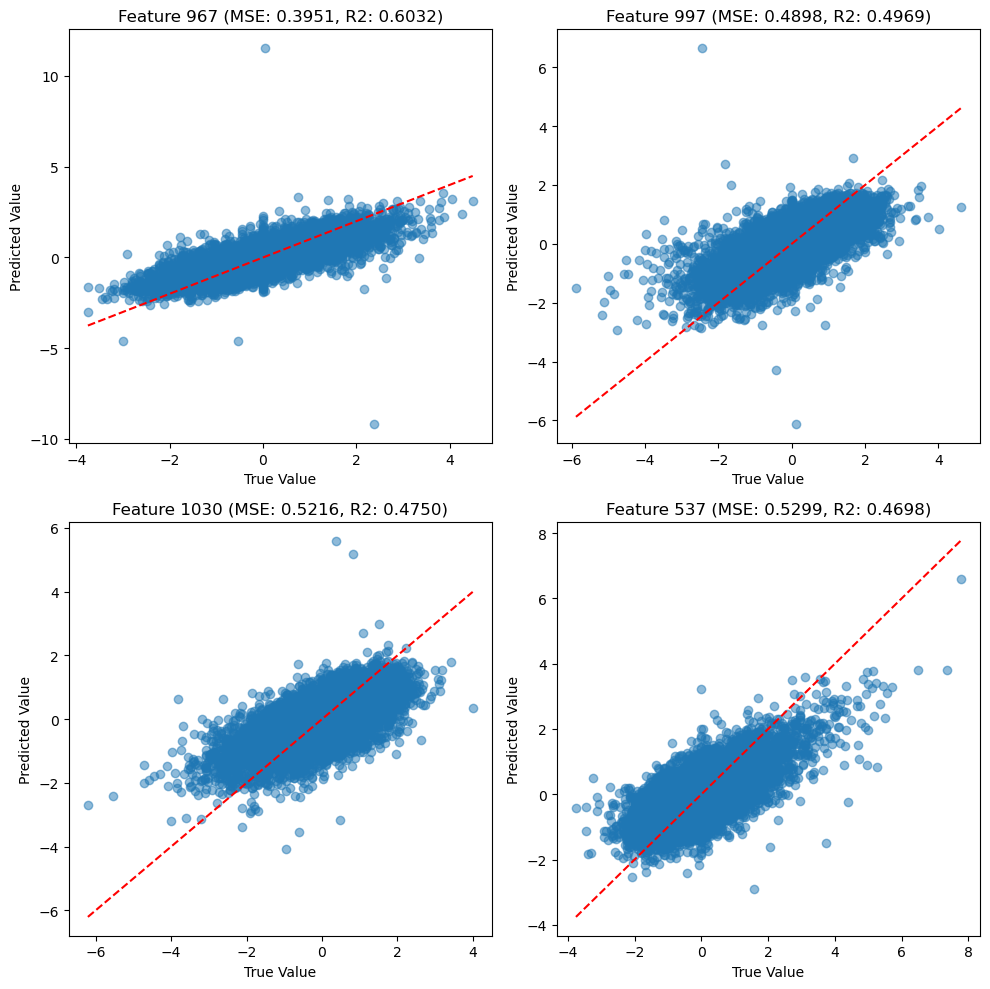

In [2]:
#you see that the results are fine! Pretty consistent with what was seen before, different features, but eh different preprocessing it seems! And dropped a ton of features, so that makes a ton of sense!

#now let's try to do the same thing but with a training loop, we can use the same CV class as before, but we need to make a training loop

#kfold import
from sklearn.model_selection import KFold

#now create a kfold with 2 splits
kf = KFold(n_splits=2, random_state=42, shuffle=True)

#now we need to do the ridge regression again
mse_list = []
f_list = []
pred_list = []
test_list = []
for train_index, test_index in kf.split(m):
    #get the indices
    m_train, m_test = m[train_index], m[test_index]
    p_train, p_test = p[train_index], p[test_index]
    test_list.append(p_test)
    #predict the data
    reg = Ridge(alpha=0.1, random_state=42).fit(m_train, p_train)
    pred = reg.predict(m_test)
    pred_list.append(pred)
    #save out the data
    #now we can calculate the mse
    mse = mean_squared_error(p_test, pred, multioutput='raw_values')
    lowest_mse = np.argsort(mse)[:4]
    f_idx = lowest_mse
    f_list.append(f_idx)
    mse_list.append(mse)
    
#now we can plot the data
plot_fct(pred_list[0], test_list[0], f_list[0], mse_list[0])

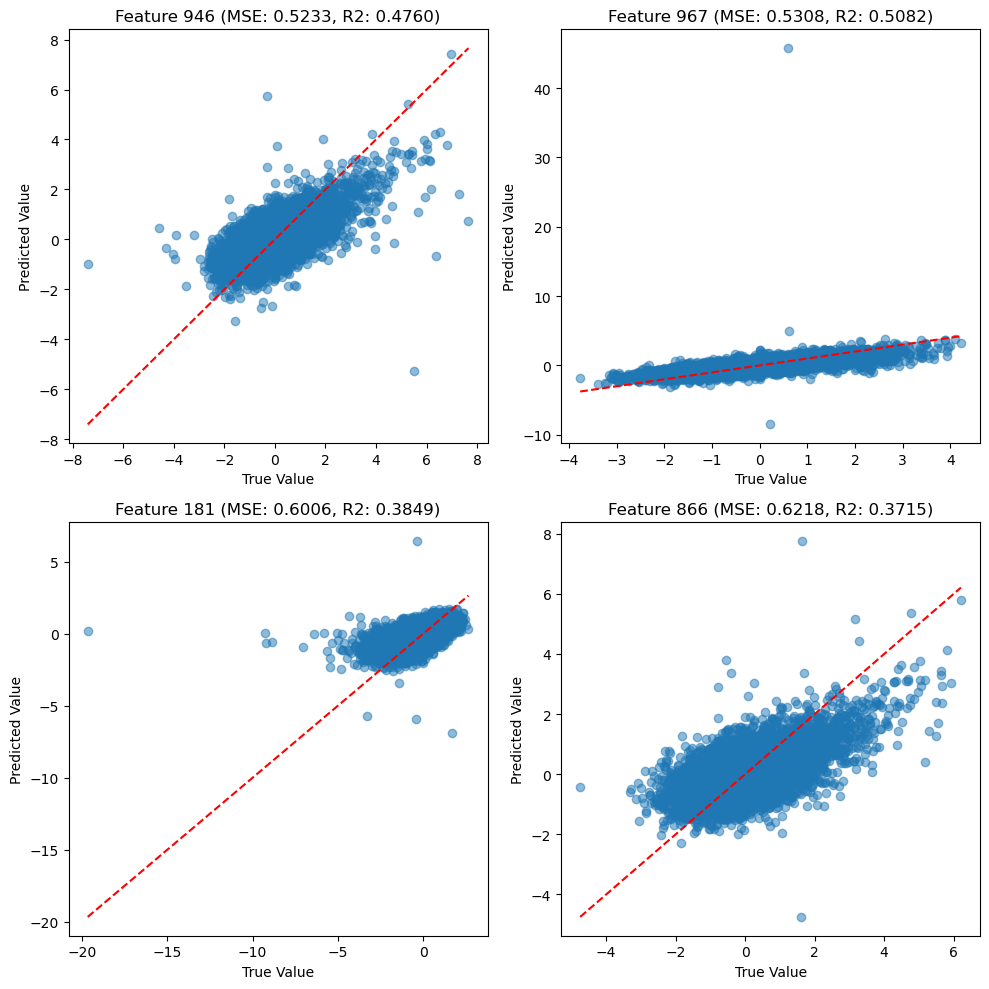

In [3]:
#now the other indices
plot_fct(pred_list[1], test_list[1], f_list[1], mse_list[1])

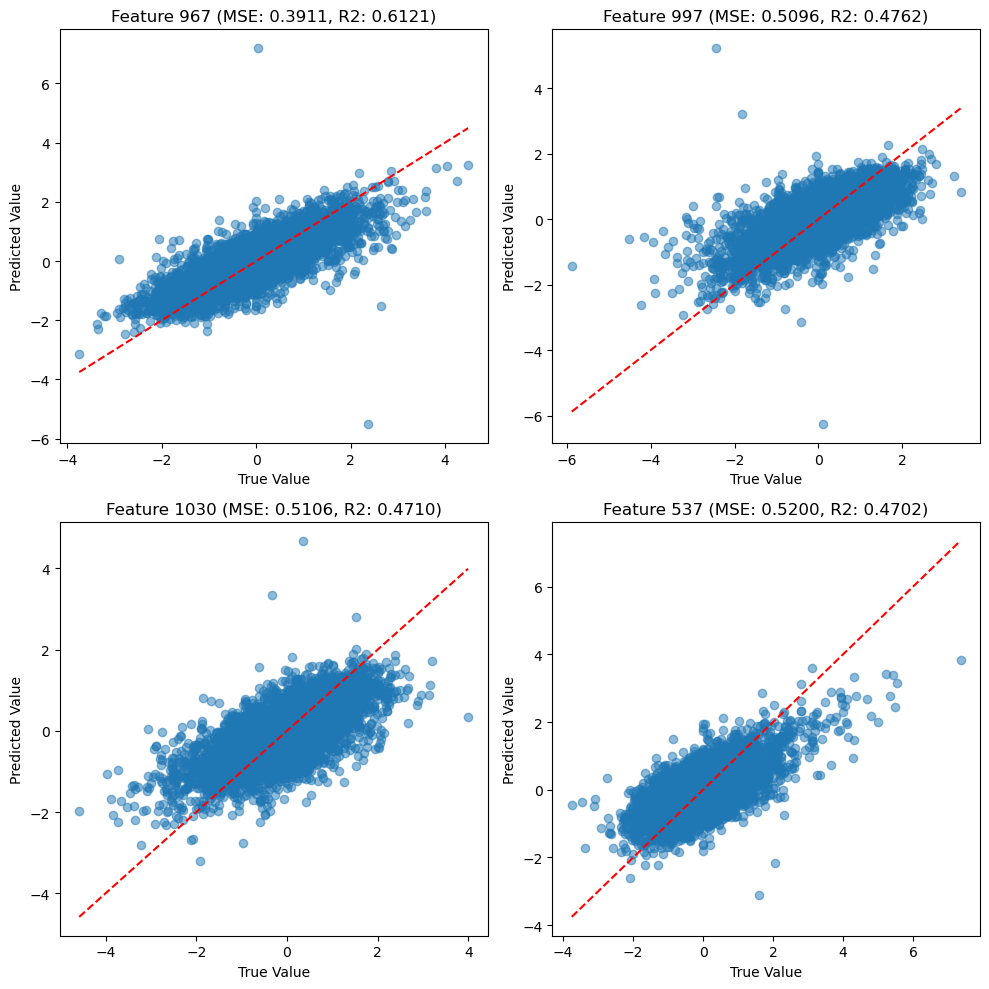

In [8]:
#now what if we were to do 5 folds?
kf = KFold(n_splits=5, random_state=42, shuffle=True)

#now we need to do the ridge regression again
mse_list = []
f_list = []
pred_list = []
test_list = []
for train_index, test_index in kf.split(m):
    #get the indices
    m_train, m_test = m[train_index], m[test_index]
    p_train, p_test = p[train_index], p[test_index]
    test_list.append(p_test)
    #predict the data
    reg = Ridge(alpha=0.1, random_state=42).fit(m_train, p_train)
    pred = reg.predict(m_test)
    pred_list.append(pred)
    #save out the data
    #now we can calculate the mse
    mse = mean_squared_error(p_test, pred, multioutput='raw_values')
    lowest_mse = np.argsort(mse)[:4]
    f_idx = lowest_mse
    f_list.append(f_idx)
    mse_list.append(mse)
    
#now we can plot the data
plot_fct(pred_list[0], test_list[0], f_list[0], mse_list[0])

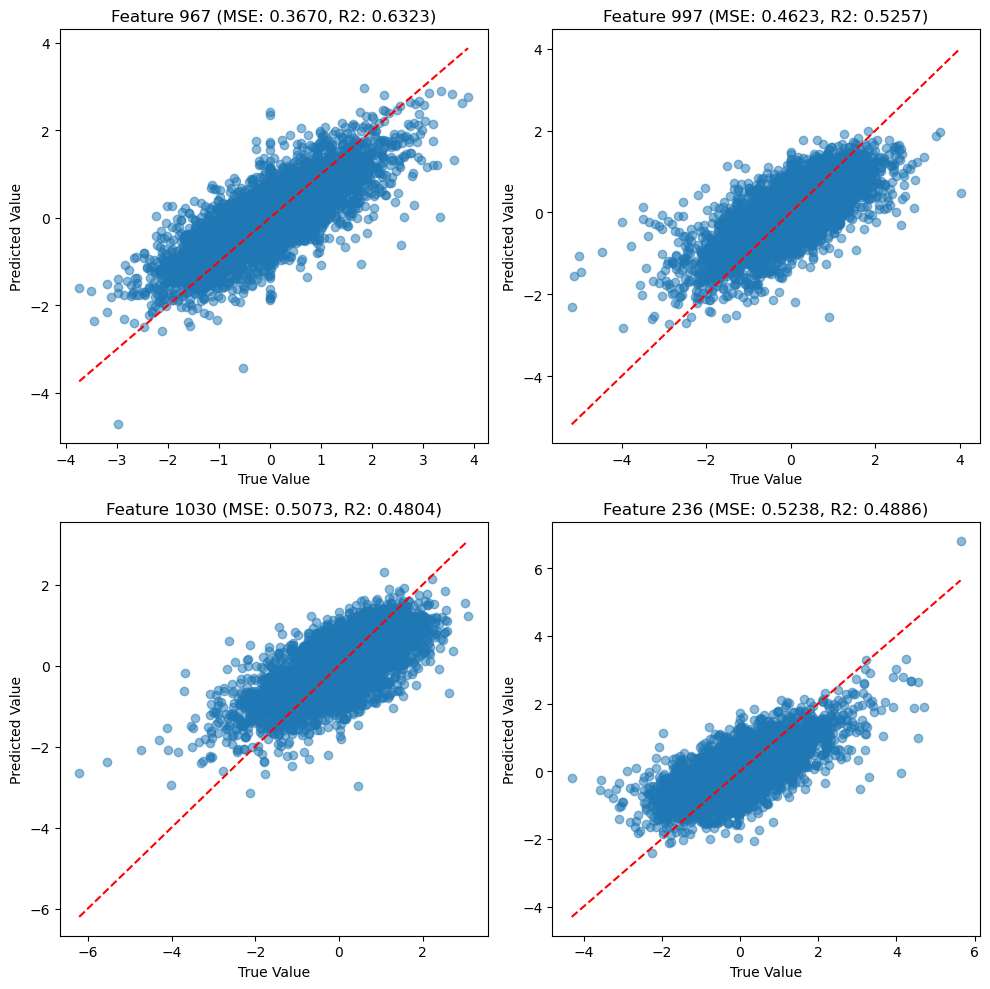

In [5]:
#nowo the next index
plot_fct(pred_list[1], test_list[1], f_list[1], mse_list[1])

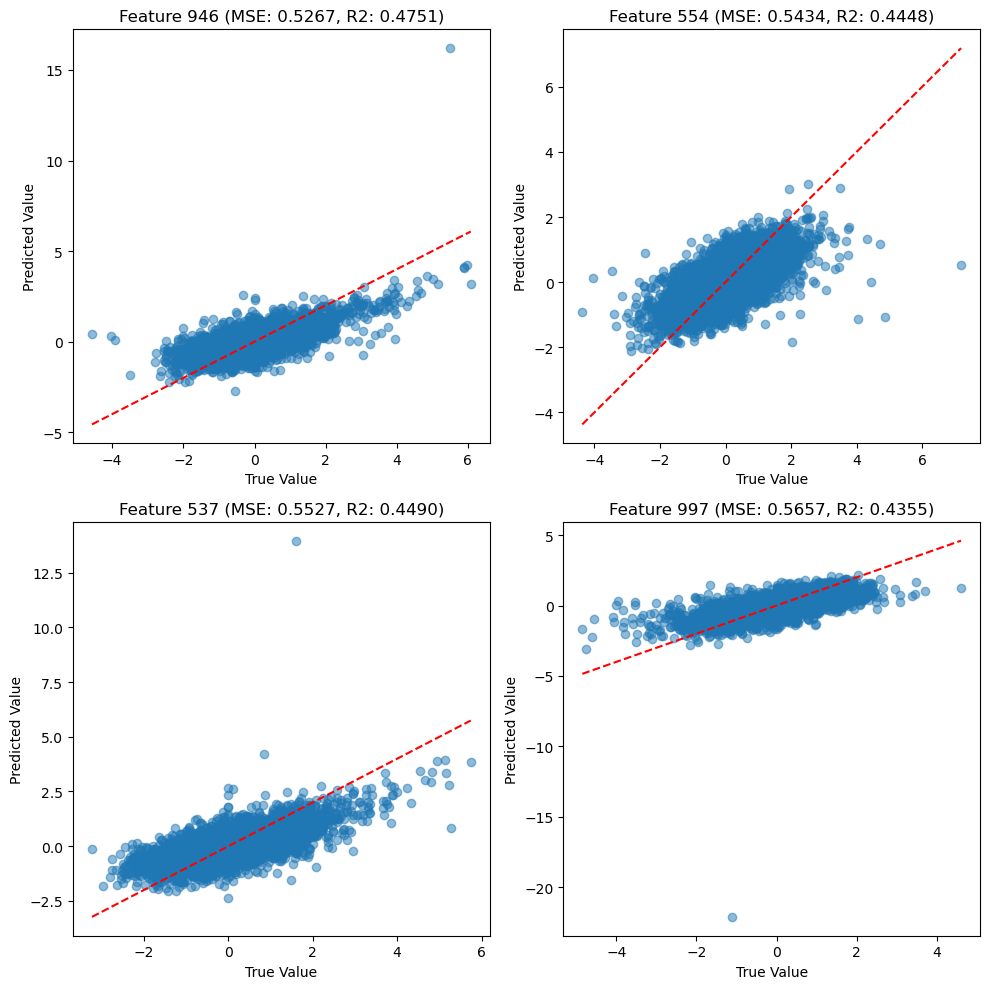

In [9]:
plot_fct(pred_list[2], test_list[2], f_list[2], mse_list[2])

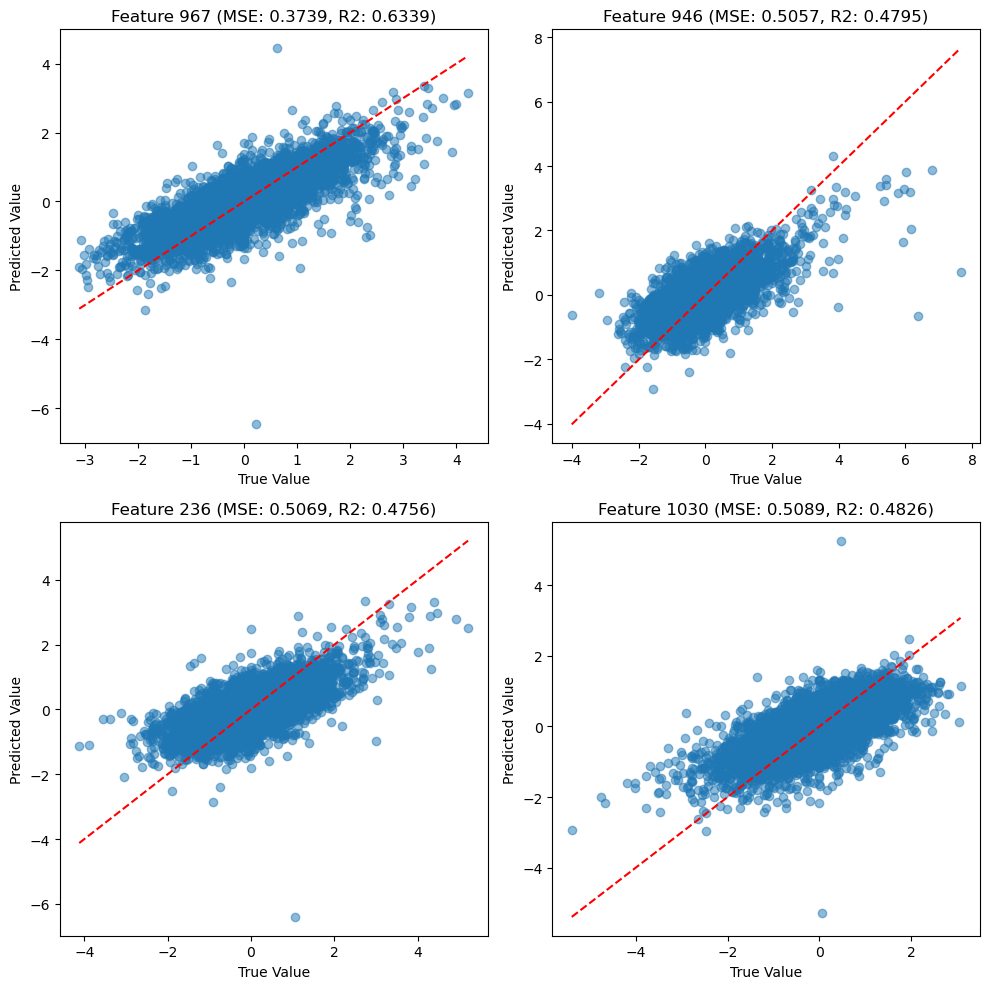

In [10]:
plot_fct(pred_list[3], test_list[3], f_list[3], mse_list[3])

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Feature 967 (MSE: 967.0000, R2: 0.5332)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 997 (MSE: 997.0000, R2: 0.4910)'}, xlabel='True Value', ylabel='Predicted Value'>],
        [<Axes: title={'center': 'Feature 946 (MSE: 946.0000, R2: 0.4795)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 537 (MSE: 537.0000, R2: 0.4649)'}, xlabel='True Value', ylabel='Predicted Value'>]],
       dtype=object))

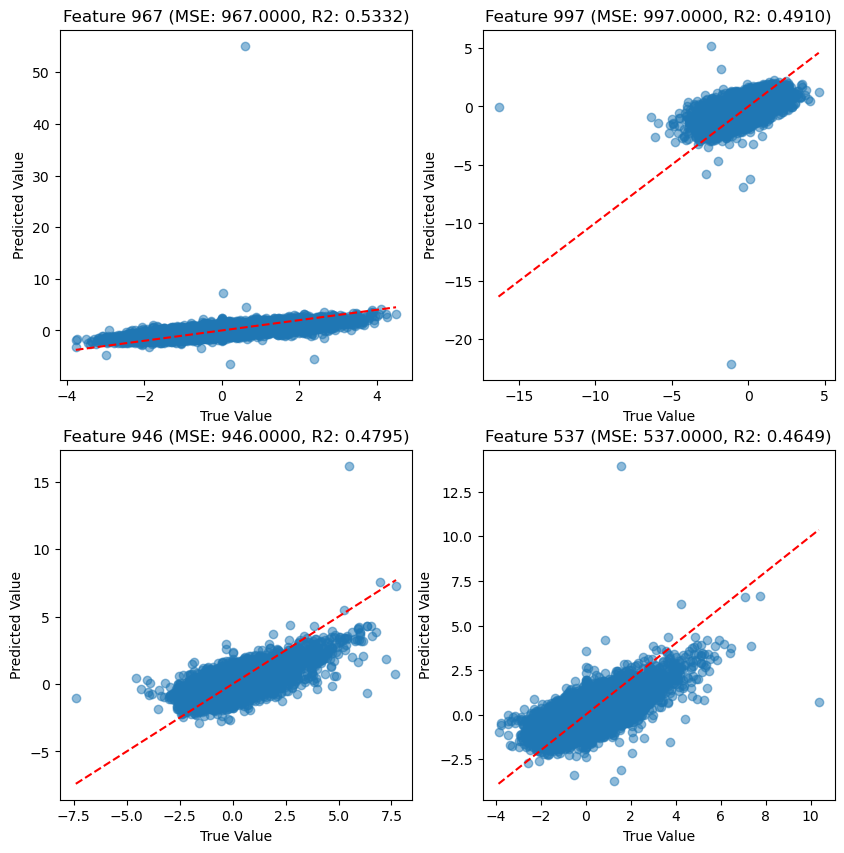

In [22]:
#as bad as it is, it's not as terrible as the cv, so there must be some sort of issue with how we are plotting that, but that's actually good to know! It might also be the mean imputation? Let's do a CV test using mean imputation, see what happens

from utils import CV
cv = CV(m,p)
fold_list = cv.folds(n = 5, random_state = 42)

#KNN algorithm is a little slow, but we do have it
for i in range(len(fold_list)):
    #get the indices
    test_idx = fold_list[i]
    #get the data
    m_train = np.delete(m, test_idx, axis = 0) #axis 0 deletes the rows with the test_idx as we hope
    m_test = m[test_idx,:]
    p_train = np.delete(p, test_idx, axis = 0)
    p_test = p[test_idx,:]
    #predict the data
    reg = Ridge(alpha=0.1, random_state=42).fit(m_train, p_train)
    pred = reg.predict(m_test)
    #save out the data
    cv.save_out(pred, i)

# mse = np.argsort(np.mean((cv.predict - p) ** 2, axis=0))[:4]
mse = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[:4]
# lowest_mse = np.argsort(mse)[:4]
cv.idx_plot(mse)

#see that it's similar features too, but despite that we can clearly see that it has very different MSE with a lot of noise... let's use sklearn definition of mse

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Feature 633 (MSE: 633.0000, R2: 0.0200)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 402 (MSE: 402.0000, R2: 0.0052)'}, xlabel='True Value', ylabel='Predicted Value'>],
        [<Axes: title={'center': 'Feature 30 (MSE: 30.0000, R2: 0.0307)'}, xlabel='True Value', ylabel='Predicted Value'>,
         <Axes: title={'center': 'Feature 903 (MSE: 903.0000, R2: 0.0042)'}, xlabel='True Value', ylabel='Predicted Value'>]],
       dtype=object))

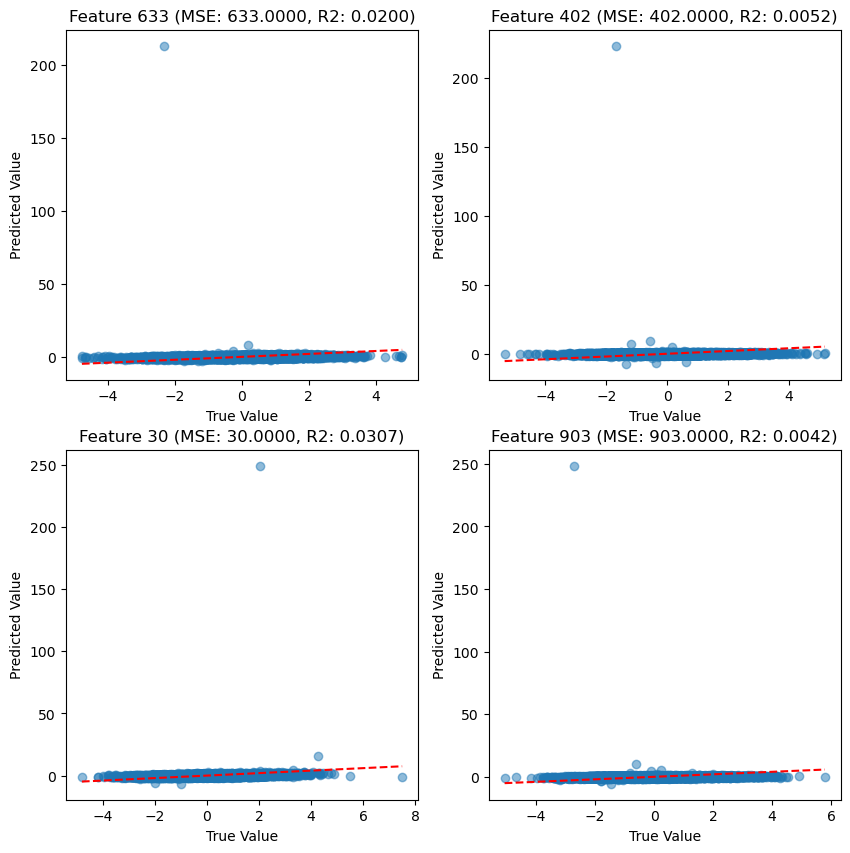

In [20]:
#also plot the highest mse
mse = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[-4:]
cv.idx_plot(mse)

In [24]:
mse = np.argsort(np.mean((cv.predict - p) ** 2, axis=0))[:4]
print(mse.shape)
mse = mean_squared_error(p, cv.predict, multioutput='raw_values')[:4]
lowest_mse = np.argsort(mse)[:4]
print(lowest_mse.shape)
print(lowest_mse)

(4,)
(4,)
[0 2 1 3]


In [ ]:













































#and we fixed the feature label, this notebook is getting too large now.

